https://pypi.org/project/pca/

In [94]:
import sys
import os
import importlib # Used during testing if I need to reload modules

import matplotlib.pyplot as plt
import numpy as np
import cv2
import scipy.stats
import scipy.signal
import pandas as pd

In [95]:
try:
    import ngif_romar.tools as tools
    import ngif_romar.plots.make_plots as plots
    import ngif_romar.plots.plots_tools as plots_tools
except ModuleNotFoundError as error:
    # If not in path/installed, use relative import
    module_path = os.path.abspath(os.path.join("."))
    sys.path.append(module_path)
    import ngif_romar.tools as tools
#    import ngif_romar.plots.make_plots as plots
#    import ngif_romar.plots.plots_tools as plots_tools

In [96]:
dataset_path = os.path.join("..", "data", "SN2", "20201001_1739_")
logfile_path = os.path.join(dataset_path, "Data.dat")
meta_dict, data_df = tools.read_data(logfile_path)
data_df = tools.post_process_log_data(data_df)

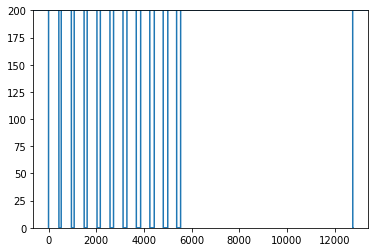

In [97]:
plt.plot(data_df['laser_on_time(ms)'])
plt.ylim([0,200])
plt.axhline(200)

11193

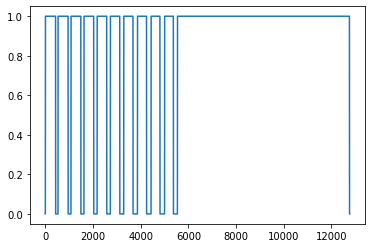

In [98]:
plt.plot(data_df['laser_on_time(ms)'] > 200)
np.count_nonzero(data_df['laser_on_time(ms)'] > 200)

In [99]:
from pca import pca
import numpy as np
data_df_filtered = data_df[
    data_df['laser_on_time(ms)'] > 200
]
print(len(data_df_filtered))
vals = data_df_filtered[['meltpoolSize','meltpoolTemp','flowWatch','protectionGlasTemperature']] 
# columns are meltpoolSize, meltpoolTemp, flowWatch, glasTemp

11193


In [103]:
model = pca(alpha=0.5,n_components=2) # alpha = threshold for outliers in t2 test
out = model.fit_transform(vals)

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed on the [4] columns of the input dataframe.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.50] and n_components=[2]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


Text(0.5, 1.0, 'Hotelling t2 ')

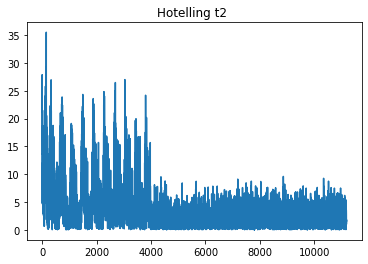

In [109]:
plt.plot(out['outliers']['y_score'].values)
plt.title('Hotelling t2 ')

In [125]:
data_df_filtered.columns

Index(['t', 'x', 'y', 'z', 'a', 'c', 'meltpoolSize', 'meltpoolTemp',
       'LaserPower', 'stirrerValue_1', 'revolutionSpeed_1', 'powderGasFlow_1',
       'stirrerValue_2', 'revolutionSpeed_2', 'powderGasFlow_2', 'flowWatch',
       'meltpoolThreshold', 'protectionGlasTemperature', 't(s)', 't(min)',
       'v_x(mm/ms)', 'v_y(mm/ms)', 'v_z(mm/ms)', '|v|(mm/ms)', 'phi(rad)',
       'r(mm)', 'phi_dot(rad/ms)', 'laser_on_time(ms)', 'laser_off_time(ms)',
       'xpart', 'ypart', 'zpart', 'toolpath_key'],
      dtype='object')

## Very noisy. If we do the same but pass a rolling window over it beforehand:

In [131]:
vals2 = data_df_filtered[['t(s)','t(min)','meltpoolSize','meltpoolTemp','flowWatch','protectionGlasTemperature']]
columns=['meltpoolSize','meltpoolTemp','flowWatch','protectionGlasTemperature']
for c in columns:
    vals2[c] = vals2[c].rolling(10,min_periods=1).mean()


<ipython-input-131-ff4e91c1301c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vals2[c] = vals2[c].rolling(10,min_periods=1).mean()


In [132]:
model2 = pca(alpha=0.5,n_components=2) # alpha = threshold for outliers in t2 test
out2 = model.fit_transform(vals2[columns])

[pca] >Cleaning previous fitted model results..
[pca] >Processing dataframe..
[pca] >The PCA reduction is performed on the [4] columns of the input dataframe.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.50] and n_components=[2]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


# Here is an example of the sort of plot we could do:

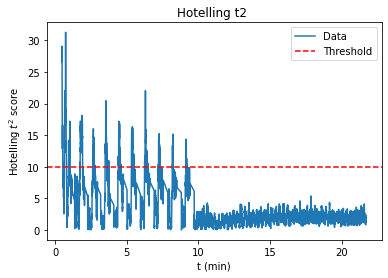

In [139]:
plt.plot(vals2['t(min)'],out2['outliers']['y_score'].values)
plt.title('Hotelling t2 ')
plt.axhline([10], color='r', linestyle='dashed') # arbitrary cutoff at 10
plt.ylabel('Hotelling $t^2$ score')
plt.xlabel('t (min)')
plt.legend(['Data','Threshold'])